# Image Alignment

Feature Matching + Homography to find Objects

* Procedure
    * Find a few important feature points (a.k.a interest points)
    * Match them across two images
    * Compute image transformation from the matches (e.g., homography)

## OpenCV

(pytorch)$ conda install -c conda-forge py-opencv


In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [32, 18]

## Feature detection

* Goal - Find points in an image that can be:
    * Found in other images
    * Found precisely – well localized
    * Found reliably – well matched

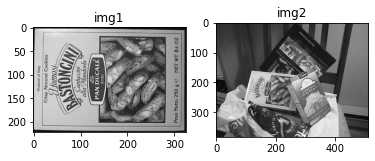

In [2]:
# read images
img1 = cv.imread('box.png', 0)  # queryImage
img2 = cv.imread('box_in_scene.png', 0)  # trainImage

plt.subplot(1,2,1), plt.imshow(img1, 'gray'), plt.title('img1')
plt.subplot(1,2,2), plt.imshow(img2, 'gray'), plt.title('img2')
plt.show()

### Detect and Compute SIFT(Scale-invariant feature transform) Features
* Create SIFT detector
    * `cv.SIFT_create([, nfeatures[, nOctaveLayers[, contrastThreshold[, edgeThreshold[, sigma]]]])`

* Detects keypoints and computes the descriptors:
    * `kp, sp = sift.detectAndCompute(image, mask[, descriptors[, useProvidedKeypoints]])`

In [3]:
# Initiate SIFT detector
# TODO
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT (mask=None)
# TODO
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

print( des1.shape)

(604, 128)


### Visualize Features
- cv.drawKeypoints(src_img, keypoints, target_img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

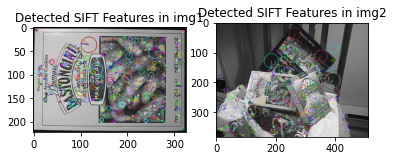

In [4]:
img1_vis = np.zeros_like(img1)
img2_vis = np.zeros_like(img2)
# img1_vis = cv.drawKeypoints(img1, kp1, img1_vis, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img1_vis = cv.drawKeypoints(img1, kp1, img1_vis, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_vis = cv.drawKeypoints(img2, kp2, img2_vis, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.subplot(1,2,1), plt.imshow(img1_vis, 'gray'), plt.title('Detected SIFT Features in img1')
plt.subplot(1,2,2), plt.imshow(img2_vis, 'gray'), plt.title('Detected SIFT Features in img2')
plt.show()

## Feature matching

* We know how to detect feature points. Next question: How to match them?
    * create the Matcher object
    * compute matches

We will use FLANN based matcher.
FLANN stands for Fast Library for Approximate Nearest Neighbors.
It contains a collection of algorithms optimized for fast nearest neighbor search in large datasets and for high dimensional features.

* Create FLANN based matcher:
    * `matcher = cv.FlannBasedMatcher([, indexParams[, searchParams]])`


* Compute matches (returns k best matches where k is specified by the user.):
    * `matches = matcher.knnMatch(queryDescriptors, trainDescriptors, k[, mask[, compactResult]])`

In [5]:
# For FLANN based matcher, we need to pass two dictionaries which specifies the algorithm to be used, its related parameters etc.
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5) # First one is IndexParams. For various algorithms, the information to be passed is explained in FLANN docs.
search_params = dict(checks=50) # Second dictionary is the SearchParams. It specifies the number of times the trees in the index should be recursively traversed. Higher values gives better precision, but also takes more time.

# Create FLANN based matcher
matcher = cv.FlannBasedMatcher(index_params, search_params)

# compute k best matches (k=2)
matches = matcher.knnMatch(des1, des2, k=2)

# store all the good matches as per Lowe's ratio test.
# matches.distance - Distance between descriptors. The lower, the better it is.
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance: # Lowe's ratio test.
        good_matches.append(m)

print(len(good_matches))

73


* Draw matched points:
    * `cv.drawMatches(img1, keypoints1, img2, keypoints2, matches1to2, outImg[, matchColor[, singlePointColor[, matchesMask[, flags]]]])`

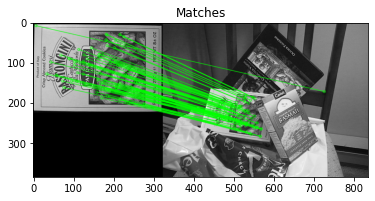

In [6]:
# draw matches
draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                   singlePointColor=None,
                   flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

img_matches = cv.drawMatches(img1, kp1, img2, kp2, good_matches, None, **draw_params)

plt.imshow(img_matches, 'gray'), plt.title('Matches')
plt.show()

## Find Homography

* We have matches now.
    * Can we estimate a transformation now?
    * No. Because of outliers (wrongly matched pairs)


There can be some possible errors while matching which may affect the result.
To solve this problem, algorithm uses RANSAC or LEAST_MEDIAN (which can be decided by the flags).
So good matches which provide correct estimation are called inliers and remaining are called outliers.


* Finds a perspective transformation between two planes:
    * `retval, mask = cv.findHomography(srcPoints, dstPoints[, method[, ransacReprojThreshold[, mask[, maxIters[, confidence]]]]])`
    * we will use `cv.RANSAC` as method and `5` as `ransacReprojThreshold`

We visualize how the images can be transformed using estimated homography.

* Applies a perspective transformation to an image:
    * `dst = cv.warpPerspective(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]])`

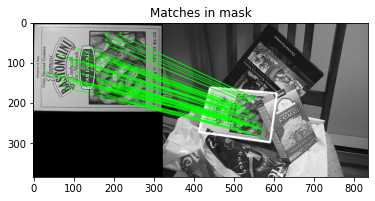

In [7]:
MIN_MATCH_COUNT = 10
if len(good_matches) > MIN_MATCH_COUNT:

    # find homography (method=cv2.RANSAC, ransacReprojThreshold=5.0)
    # TODO
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5)
    matchesMask = mask.ravel().tolist()

    # perspective transform
    h, w = img1.shape
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv.perspectiveTransform(pts, M)
        
    # draw box
    img2_box = cv.polylines(img2.copy(), [np.int32(dst)], True, 255, 3, cv.LINE_AA)
else:
    print("Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT))
    matchesMask = None

# draw matches
draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                   singlePointColor=None,
                   matchesMask=matchesMask,  # draw only inliers
                   flags=2)

img3 = cv.drawMatches(img1, kp1, img2_box, kp2, good_matches, None, **draw_params)



plt.imshow(img3, 'gray'), plt.title('Matches in mask')
plt.show()

### Image Warping
- hint: use `np.linalg.inv(matrix)` to get inverse matrix

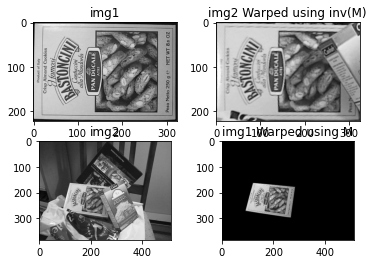

In [9]:
# warp images using homography matrix M
# TODO
# warp img1 to img2 space using M
img1_warped = cv.warpPerspective(img1, M, dsize=(img2.shape[1],img2.shape[0])) # (dsize=(img2.shape[1],img2.shape[0]))
# warp img2 to img1 space using inverse of M
img2_warped = cv.warpPerspective(img2, np.linalg.inv(M), dsize=(img1.shape[1],img1.shape[0])) # (dsize=(img1.shape[1],img1.shape[0]))

plt.subplot(2,2,1), plt.imshow(img1, 'gray'), plt.title('img1')
plt.subplot(2,2,2), plt.imshow(img2_warped, 'gray'), plt.title('img2 Warped using inv(M)')
plt.subplot(2,2,3), plt.imshow(img2, 'gray'), plt.title('img2')
plt.subplot(2,2,4), plt.imshow(img1_warped, 'gray'), plt.title('img1 Warped using M')
plt.show()